### Using HORDE dataset to fetch mouse and Human Olfactory Receptors and comparing them across receptor lengths 

In [1]:
import csv

def parse_fasta(filename):
    """
    Parses a FASTA-formatted file and returns a dictionary mapping receptor names to sequences.
    """
    sequences = {}
    with open(filename, "r") as f:
        header = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if header is not None:
                    sequences[header] = "".join(seq_lines)
                header = line[1:]  # remove the '>' character
                seq_lines = []
            else:
                seq_lines.append(line)
        if header is not None:
            sequences[header] = "".join(seq_lines)
    return sequences

def parse_mouse_file(filename):
    """
    Parses a tab-delimited file where the first column is the receptor name and
    the second column is the peptide sequence. Returns a dictionary mapping receptor names to sequences.
    """
    sequences = {}
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split("\t")
            if len(parts) >= 2:
                receptor = parts[0].strip()
                seq = parts[1].strip()
                sequences[receptor] = seq
    return sequences

def main():
    human_file = "conceptual.txt"
    mouse_file = "mouse_pep_July19.txt"
    output_csv = "olfactory_receptors.csv"
    
    # Parse the human FASTA file and the mouse tab-delimited file
    human_data = parse_fasta(human_file)
    mouse_data = parse_mouse_file(mouse_file)
    
    # For matching, convert keys to uppercase.
    # We keep the original keys as well so we can output them as they appear in each file.
    human_data_upper = {k.upper(): (k, v) for k, v in human_data.items()}
    mouse_data_upper = {k.upper(): (k, v) for k, v in mouse_data.items()}
    
    # Identify common receptor names (by uppercase)
    common_keys = set(human_data_upper.keys()) & set(mouse_data_upper.keys())
    
    with open(output_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        # Write header with 4 columns
        writer.writerow(["OR_human", "human_SEQUENCE", "OR_mouse", "mouse_SEQUENCE"])
        
        # For each receptor found in both files, write a row.
        for key in sorted(common_keys):
            human_original, human_seq = human_data_upper[key]
            mouse_original, mouse_seq = mouse_data_upper[key]
            writer.writerow([human_original, human_seq, mouse_original, mouse_seq])
    
    print(f"CSV file '{output_csv}' created with {len(common_keys)} matched receptor pairs.")

if __name__ == "__main__":
    main()


CSV file 'olfactory_receptors.csv' created with 210 matched receptor pairs.


### Assessing the %similarity using sequence alignment between the sequences 

In [2]:
import csv
from Bio import pairwise2

def calc_identity(seq1, seq2):
    """
    Performs a global alignment using a simple match (1) / mismatch (0) scoring,
    and returns the percentage of identical positions in the best alignment.
    """
    alignments = pairwise2.align.globalxx(seq1, seq2)
    best_alignment = alignments[0]  # Use the best alignment
    aligned_seq1, aligned_seq2, score, start, end = best_alignment

    # Count the number of identical positions
    identical = sum(1 for a, b in zip(aligned_seq1, aligned_seq2) if a == b)
    identity_percentage = (identical / len(aligned_seq1)) * 100
    return identity_percentage

def main():
    input_csv = "olfactory_receptors.csv"
    output_csv = "olfactory_receptors_with_homology.csv"

    with open(input_csv, "r", newline="") as infile, open(output_csv, "w", newline="") as outfile:
        reader = csv.DictReader(infile)
        # Add a new column "Homology" for the percentage similarity
        fieldnames = reader.fieldnames + ["Homology"]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            human_seq = row["human_SEQUENCE"]
            mouse_seq = row["mouse_SEQUENCE"]
            # Calculate percentage identity (homology)
            homology = calc_identity(human_seq, mouse_seq)
            row["Homology"] = f"{homology:.2f}"
            writer.writerow(row)

    print(f"CSV file '{output_csv}' created with an added 'Homology' column.")

if __name__ == "__main__":
    main()


/opt/anaconda3/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


CSV file 'olfactory_receptors_with_homology.csv' created with an added 'Homology' column.


## Finding their pLDDT


In [5]:
import csv
import requests

def fetch_uniprot_id(gene, organism):
    """
    Given a gene name and organism (taxonomic ID), query the UniProt API to get the primary accession ID.
    For humans use organism "9606" and for mouse use "10090".
    """
    base_url = "https://rest.uniprot.org/uniprotkb/search"
    # Use organism_id instead of organism
    query = f"gene_exact:{gene} AND organism_id:{organism}"
    params = {
        "query": query,
        "format": "json",
        "fields": "accession"
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        if "results" in data and len(data["results"]) > 0:
            # The primary accession is usually under the key "primaryAccession"
            uniprot_id = data["results"][0].get("primaryAccession")
            return uniprot_id
        else:
            print(f"[Warning] No UniProt entry found for gene '{gene}' (organism {organism})")
            return None
    except Exception as e:
        print(f"[Error] Could not fetch UniProt ID for gene '{gene}' (organism {organism}): {e}")
        return None

def main():
    input_csv = "olfactory_receptors_with_homology.csv"
    output_csv = "olfactory_receptors_with_uniprot.csv"

    with open(input_csv, newline='') as infile, open(output_csv, 'w', newline='') as outfile:
        reader = csv.DictReader(infile)
        # Extend the CSV columns to include UniProt IDs for human and mouse proteins.
        fieldnames = reader.fieldnames + ["human_uniprot", "mouse_uniprot"]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()

        for row in reader:
            human_gene = row["OR_human"]
            mouse_gene = row["OR_mouse"]

            # For humans, use organism_id 9606; for mouse, use 10090.
            human_uniprot = fetch_uniprot_id(human_gene, "9606")
            mouse_uniprot = fetch_uniprot_id(mouse_gene, "10090")

            row["human_uniprot"] = human_uniprot if human_uniprot is not None else "N/A"
            row["mouse_uniprot"] = mouse_uniprot if mouse_uniprot is not None else "N/A"

            writer.writerow(row)

    print(f"CSV file '{output_csv}' created with UniProt IDs for human and mouse receptors.")

if __name__ == "__main__":
    main()


[Warning] No UniProt entry found for gene 'Or13c9' (organism 10090)
[Warning] No UniProt entry found for gene 'Or6k3' (organism 10090)
CSV file 'olfactory_receptors_with_uniprot.csv' created with UniProt IDs for human and mouse receptors.


In [2]:
import requests

def fetch_overall_plddt(uniprot_id):
    """
    Fetch overall model confidence (average pLDDT) for a given UniProt accession 
    using the AlphaFold summary API.
    
    The endpoint returns a JSON object containing a list of structure summaries.
    We extract the first summary’s 'confidence_avg_local_score'.
    
    Parameters:
        uniprot_id (str): The UniProt accession (e.g. 'Q9H208').
        
    Returns:
        float or None: The overall confidence score if available, otherwise None.
    """
    url = f"https://www.alphafold.ebi.ac.uk/api/uniprot/summary/{uniprot_id}.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        structures = data.get("structures", [])
        if structures:
            summary = structures[0].get("summary", {})
            confidence = summary.get("confidence_avg_local_score")
            if confidence is not None:
                return confidence
            else:
                print(f"[Warning] 'confidence_avg_local_score' not found for {uniprot_id}")
        else:
            print(f"[Warning] No structures found in summary for {uniprot_id}")
    except Exception as e:
        print(f"[Error] Could not fetch data for {uniprot_id}: {e}")
    return None

# Example usage:
if __name__ == "__main__":
    uniprot_ids = ["Q9H208", "P58181", "Q9H207"]  # Replace with your desired UniProt IDs
    for uid in uniprot_ids:
        score = fetch_overall_plddt(uid)
        if score is not None:
            print(f"Overall model confidence for {uid}: {score:.2f}")
        else:
            print(f"Overall model confidence for {uid}: N/A")


Overall model confidence for Q9H208: 84.87
Overall model confidence for P58181: 89.19
Overall model confidence for Q9H207: 89.11


In [3]:
import csv
import requests

def fetch_overall_plddt(uniprot_id):
    """
    Fetch the overall model confidence (average pLDDT score) for a given UniProt ID
    using the AlphaFold summary API endpoint.
    
    Returns:
        float or None: The overall pLDDT score if available, otherwise None.
    """
    url = f"https://www.alphafold.ebi.ac.uk/api/uniprot/summary/{uniprot_id}.json"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        structures = data.get("structures", [])
        if not structures:
            print(f"[Warning] No structures found for {uniprot_id}")
            return None
        summary = structures[0].get("summary", {})
        score = summary.get("confidence_avg_local_score")
        if score is None:
            print(f"[Warning] 'confidence_avg_local_score' not found for {uniprot_id}")
        return score
    except Exception as e:
        print(f"[Error] Could not fetch pLDDT for {uniprot_id}: {e}")
        return None

def main():
    input_csv = "olfactory_receptors_with_uniprot.csv"
    output_csv = "olfactory_receptors_with_avg_plddt.csv"
    
    with open(input_csv, newline="") as infile, open(output_csv, "w", newline="") as outfile:
        reader = csv.DictReader(infile)
        # Extend the CSV columns to include the new pLDDT scores.
        fieldnames = reader.fieldnames + ["human_avg_pLDDT", "mouse_avg_pLDDT"]
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)
        writer.writeheader()
        
        for row in reader:
            human_uniprot = row.get("human_uniprot", "N/A")
            mouse_uniprot = row.get("mouse_uniprot", "N/A")
            
            human_avg = fetch_overall_plddt(human_uniprot) if human_uniprot != "N/A" else None
            mouse_avg = fetch_overall_plddt(mouse_uniprot) if mouse_uniprot != "N/A" else None
            
            row["human_avg_pLDDT"] = f"{human_avg:.2f}" if human_avg is not None else "N/A"
            row["mouse_avg_pLDDT"] = f"{mouse_avg:.2f}" if mouse_avg is not None else "N/A"
            
            writer.writerow(row)
    
    print(f"CSV file '{output_csv}' created with human_avg_pLDDT and mouse_avg_pLDDT columns.")

if __name__ == "__main__":
    main()


[Error] Could not fetch pLDDT for Q62331: 404 Client Error: Not Found for url: https://www.alphafold.ebi.ac.uk/api/uniprot/summary/Q62331.json
[Error] Could not fetch pLDDT for Q62333: 404 Client Error: Not Found for url: https://www.alphafold.ebi.ac.uk/api/uniprot/summary/Q62333.json
CSV file 'olfactory_receptors_with_avg_plddt.csv' created with human_avg_pLDDT and mouse_avg_pLDDT columns.


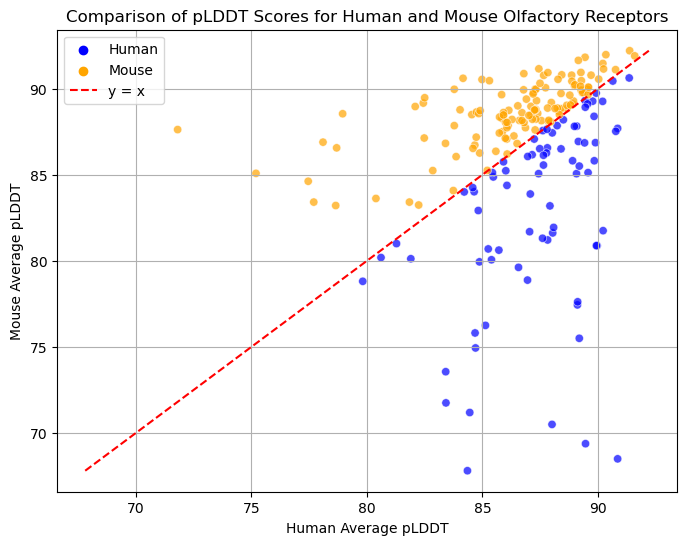

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV
df = pd.read_csv("olfactory_receptors_with_avg_plddt.csv")

# Convert columns to numeric
df["human_avg_pLDDT"] = pd.to_numeric(df["human_avg_pLDDT"], errors="coerce")
df["mouse_avg_pLDDT"] = pd.to_numeric(df["mouse_avg_pLDDT"], errors="coerce")

# Drop rows with missing values
df.dropna(subset=["human_avg_pLDDT", "mouse_avg_pLDDT"], inplace=True)

# Compute difference
df["pLDDT_diff"] = df["human_avg_pLDDT"] - df["mouse_avg_pLDDT"]

# Create a column for which species is higher
# (If they tie exactly, label them 'Tie')
df["species_higher"] = np.where(
    df["pLDDT_diff"] > 0, "Human",
    np.where(df["pLDDT_diff"] < 0, "Mouse", "Tie")
)

# Scatter plot using Seaborn, colored by which species is higher
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="human_avg_pLDDT",
    y="mouse_avg_pLDDT",
    hue="species_higher",
    palette={"Human": "blue", "Mouse": "orange", "Tie": "green"},
    alpha=0.7
)

# Add the diagonal y=x line for reference
min_val = min(df["human_avg_pLDDT"].min(), df["mouse_avg_pLDDT"].min())
max_val = max(df["human_avg_pLDDT"].max(), df["mouse_avg_pLDDT"].max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="y = x")

plt.xlabel("Human Average pLDDT")
plt.ylabel("Mouse Average pLDDT")
plt.title("Comparison of pLDDT Scores for Human and Mouse Olfactory Receptors")
plt.legend()
plt.grid(True)
plt.show()



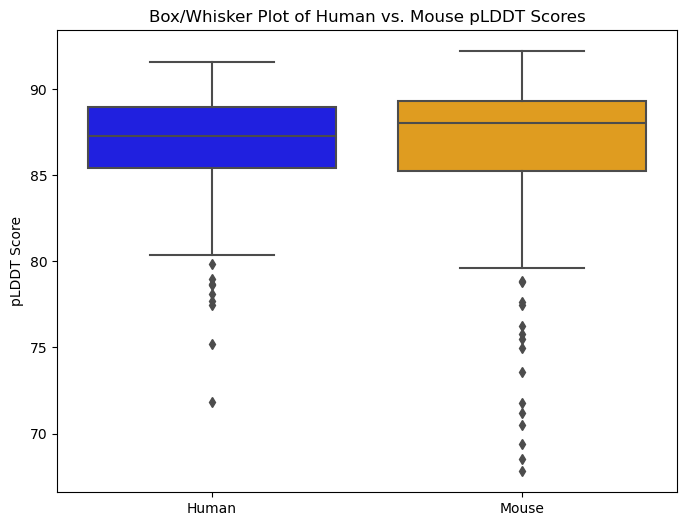

Two-sample T-test (Welch’s) Results:
  T-statistic: 0.5420
  P-value:     5.8815e-01


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def main():
    # 1. Read CSV
    df = pd.read_csv("olfactory_receptors_with_avg_plddt.csv")

    # Convert pLDDT columns to numeric
    df["human_avg_pLDDT"] = pd.to_numeric(df["human_avg_pLDDT"], errors="coerce")
    df["mouse_avg_pLDDT"] = pd.to_numeric(df["mouse_avg_pLDDT"], errors="coerce")

    # Drop rows with missing values
    df.dropna(subset=["human_avg_pLDDT", "mouse_avg_pLDDT"], inplace=True)

    # Extract numeric arrays for the two groups
    human_scores = df["human_avg_pLDDT"]
    mouse_scores = df["mouse_avg_pLDDT"]

    # 2. Box-and-Whisker Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[human_scores, mouse_scores], palette=["blue", "orange"])
    plt.xticks([0, 1], ["Human", "Mouse"])
    plt.title("Box/Whisker Plot of Human vs. Mouse pLDDT Scores")
    plt.ylabel("pLDDT Score")
    plt.show()

    # 3. Two-Sample T-Test
    # By default, scipy.stats.ttest_ind assumes equal variance. 
    # If you prefer a Welch's t-test (which doesn't assume equal variance), set `equal_var=False`.
    t_stat, p_value = stats.ttest_ind(human_scores, mouse_scores, equal_var=False)

    print(f"Two-sample T-test (Welch’s) Results:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value:     {p_value:.4e}")

if __name__ == "__main__":
    main()


In [7]:
import pandas as pd
from scipy import stats
import numpy as np

# Load the CSV file
df = pd.read_csv("olfactory_receptors_with_avg_plddt.csv")

# Convert pLDDT columns to numeric (coerce errors to NaN) and drop missing values
df["human_avg_pLDDT"] = pd.to_numeric(df["human_avg_pLDDT"], errors="coerce")
df["mouse_avg_pLDDT"] = pd.to_numeric(df["mouse_avg_pLDDT"], errors="coerce")
df = df.dropna(subset=["human_avg_pLDDT", "mouse_avg_pLDDT"])

# Compute the paired differences (human - mouse)
df["diff"] = df["human_avg_pLDDT"] - df["mouse_avg_pLDDT"]

# Perform a paired t-test
t_stat, p_value = stats.ttest_rel(df["human_avg_pLDDT"], df["mouse_avg_pLDDT"])
print("Paired t-test results:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.4e}")

# Calculate effect size (Cohen's d for paired samples)
mean_diff = df["diff"].mean()
std_diff = df["diff"].std(ddof=1)  # sample standard deviation
cohens_d = mean_diff / std_diff
print("Effect size (Cohen's d):", cohens_d)


Paired t-test results:
  T-statistic: 0.6156
  P-value: 5.3884e-01
Effect size (Cohen's d): 0.0426840182223938
